# Beam-cleaning simulation

Following below tests, we can get beam-cleaning of GRIN rod
* Test1 : The input beam of LP01 mode in single mode fiber. The expected output beam will be the same as the input beam.

* Test2 : The input beam of LP01 mode in multimode fiber. The expected output beam will be the same as the input beam.

* Test3 : The input beam of LP11 mode in multimode fiber. The expected output beam will be the same as the input beam.

* Test4 : The input beam of (0.3 * LP01 + 0.7 LP11) mode in multimode fiber is given, the output beam will be calculated by the superposition of propagation of each mode.

* Test5 : The input beam is arbitrary, the input beam can be decomposed and calculated by the superposition of each mode.

* Test6 : Self-imaging in GRIN fiber in 3D isosurface plot.

* Test7 : Kerr self-beam cleaning in GRIN fiber. The fundamental mode content are dominant after propagation.

* Test8 : Self-imaging in GRIN rod.

* Test9 : Self-imaging in GRIN rod with edge excitation.

* Test10 : Kerr self-beam cleaning in GRIN rod. The input beam is on-axis gaussian. The fundamental mode content are dominant after propagation.

* Test11 : Kerr self-beam cleaning in GRIN rod. The input beam is off-axis gaussian.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import torch
import os

In [2]:
plt.rcParams['font.size'] = 13
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Basic parameters

In [3]:
c = 299792458

n_core = 1.457
n_clad = 1.45
print(f'NA = {np.sqrt(n_core**2 - n_clad**2)}')

wvl0 = 775e-9 # Wavelength (meter)

NA = 0.14264992113562627


In [4]:
def plot_index_profile(n):
    if type(n) == torch.Tensor:
        n = n.cpu().numpy()
    fig, ax = plt.subplots()
    im = ax.imshow(n, cmap='Blues')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    fig.colorbar(im, cax=cax)

In [29]:
def plot_beam_intensity(field, indices=None, extent=None):
    if type(field) == torch.Tensor:
        field = field.cpu().numpy()
    fig, ax = plt.subplots()
    
    eps = 1e-5
    extent = [-3000, 3000, -3000, 3000]
    xtick = np.linspace(0, field.shape[1]+eps, 5)
    ytick = np.linspace(0, field.shape[0]+eps, 5)
    xlabel = np.linspace(extent[0], extent[1], 5)
    ylabel = np.linspace(extent[2], extent[3], 5)
    im = ax.imshow(np.abs(field)**2, cmap='jet',)
    ax.set_xticks(xtick)
    ax.set_yticks(ytick)
    ax.set_xticklabels([f'{x}' for x in xlabel])
    ax.set_yticklabels([f'{y}' for y in ylabel])
    ax.set_xlabel(r'x ($\mu m$)')
    ax.set_ylabel(r'y ($\mu m$)')
    # divider = make_axes_locatable(ax)
    # cax = divider.append_axes("right", size="5%", pad=0.1)
    # fig.colorbar(im, cax=cax)

    if indices is not None:
        if type(indices) == torch.Tensor:
            indices = indices.cpu().numpy()
        ax.contour(indices, levels=[1.45], colors='white', linewidths=2)


## Create simulation

In [6]:
def generate_grids(Lx, Ly, Nx, Ny, device='cpu'):
    x = torch.linspace(-Lx/2, Lx/2, Nx, device=device, dtype=torch.float64)
    y = torch.linspace(-Ly/2, Ly/2, Ny, device=device, dtype=torch.float64)
    X, Y = torch.meshgrid(x, y, indexing='ij')
    return X, Y

In [7]:
def generate_freqs(Lx, Ly, Nx, Ny, device='cpu'):
    kx = torch.fft.fftfreq(Nx, d=Lx/Nx).to(device) * 2 * torch.pi
    ky = torch.fft.fftfreq(Ny, d=Ly/Ny).to(device) * 2 * torch.pi

    # kx = (2 * np.pi / Lx) * torch.fft.fftfreq(Nx, d=Lx/Nx/(2*torch.pi)).to(device)
    # ky = (2 * np.pi / Ly) * torch.fft.fftfreq(Ny, d=Ly/Ny/(2*torch.pi)).to(device)
    KX, KY = torch.meshgrid(kx, ky, indexing='ij')
    return KX, KY

In [8]:
class Domain:
    def __init__(self, Lx, Ly, Nx, Ny):
        self.Lx = Lx
        self.Ly = Ly
        self.Nx = Nx
        self.Ny = Ny
        self.X, self.Y = generate_grids(Lx, Ly, Nx, Ny, device=device)
        self.KX, self.KY = generate_freqs(Lx, Ly, Nx, Ny, device=device)

In [9]:
class Fiber:
    def __init__(self, domain, n_core, n_clad, total_z, dz, radius=5e-6, n2=0, structure_type="GRIN"):
        self.domain = domain
        self.n_core = n_core
        self.n_clad = n_clad
        self.radius = radius
        
        self.total_z = total_z
        self.dz = dz
        self.n_step = int(total_z / dz)
        self.n2 = n2

        if structure_type == "GRIN":
            self.n = self.GRIN_fiber()
        
    def GRIN_fiber(self,):
        n = torch.zeros_like(self.domain.X)
        R = torch.sqrt(self.domain.X**2 + self.domain.Y**2)
        delta = (n_core**2 - n_clad**2) / (2 * n_core**2)
        
        n[torch.where(R > self.radius)] = n_clad
        n[torch.where(R <= self.radius)] = n_core * torch.sqrt(1 - 2 * delta * (R[torch.where(R <= self.radius)]/self.radius)**2)

        return n


In [10]:
import mmfsim.grid as grids
import mmfsim.beams as beams
from mmfsim.coupling import GrinFiberCoupler
from mmfsim.fiber import GrinFiber
from mmfsim.modes import GrinLPMode



In [34]:
class Input:
    def __init__(self, domain, wvl0, n_core, n_clad, radius=5e-6, num_mode=0, normalization=True, coefficients=None,
                 coefficients2=None,  amp=1.0, gaussian=False, cx=0, cy=0,mode=None, device='cpu'):
        self.domain = domain
        self.wvl0 = wvl0
        self.n_core = n_core
        self.n_clad = n_clad
        self.radius = radius
        self.normalization = normalization
        self.amp = amp

        if gaussian:
            self.field = self.gaussian_beam(50e-6, cx=cx, cy=cy)
        elif num_mode == 0:
            # self.field = self.generate_LP_modes(device=device)
            self.field = self.LP_modes(mode[0], mode[1], coefficients2)
        else:
            self.field = self.mode_mixing(num_mode, coefficients, coefficients2)

    def gaussian_beam(self, w, cx=0, cy=0):
        R = torch.sqrt((self.domain.X-cx)**2 + (self.domain.Y-cy)**2)
        field = torch.exp(-R**2 / w**2)
        field = field / torch.max(torch.abs(field)) * self.amp
        return field

    def LP_modes(self, m, l, coefficients2=None, device='cuda'):
        grid = grids.Grid(pixel_size=self.domain.Lx/self.domain.Nx, pixel_numbers=(self.domain.Nx, self.domain.Ny))
        grin_fiber = GrinFiber(radius=self.radius, wavelength=self.wvl0, n1=self.n_core, n2=self.n_clad)
        mode = GrinLPMode(m, l)
        mode.compute(grin_fiber, grid)
        if coefficients2 is not None:
            m = coefficients2
        field = torch.tensor(mode._fields[:, :, m])
        
        if self.normalization:
            summation = torch.sum(torch.abs(field)**2)
            field = field / torch.sqrt(summation)
        return field.to(device)
        # mode.plot()

    def mode_mixing(self, num_mode, coefficients=None, coefficients2=None, device='cuda'):
        self.modes_indices = ((0, 1), (0, 2), (1, 1), (0, 3), (1, 2), (2, 1), (0, 4), (1, 3), (2, 2), (3, 1), (0, 5), (1, 4), (2, 3), (3, 2), (4, 1))
        grid = grids.Grid(pixel_size=self.domain.Lx/self.domain.Nx, pixel_numbers=(self.domain.Nx, self.domain.Ny))
        grin_fiber = GrinFiber(radius=self.radius, wavelength=self.wvl0, n1=self.n_core, n2=self.n_clad)
        total_field = torch.zeros_like(self.domain.X, dtype=torch.complex128).to('cpu')
        for i in range(num_mode):
            indices = self.modes_indices[i]
            mode = GrinLPMode(indices[0], indices[1])
            mode.compute(grin_fiber, grid)
            if coefficients2 is not None:
                m = coefficients2[i]
            else:
                m = 0
            summation = torch.sum(torch.abs(torch.tensor(mode._fields[:, :, m]))**2)
            field = torch.tensor(mode._fields[:, :, m]) / torch.sqrt(summation) 
            total_field += field * coefficients[i]
        total_field = total_field * self.amp
        return total_field.to(device)

            


## GRIN Fiber

In [ ]:
radius = 10e-6
Lx, Ly = 100e-6, 100e-6
Nx, Ny = 512, 512
total_z = 1e-2
dz=1e-6

In [ ]:
domain = Domain(Lx, Ly, Nx, Ny)
input_beam = Input(domain, wvl0, n_core, n_clad, radius=radius, mode=(2, 2))
fiber = Fiber(domain, n_core, n_clad, total_z, dz, radius=radius)

In [ ]:
plot_beam_intensity(input_beam.field, indices=fiber.n)

In [ ]:
plot_index_profile(fiber.n)

## Single mode fiber

# Run simulation

In [12]:
def run(domain, input, fiber, wvl0, n_sample=100, nonlinear=False, device='cpu'):
    
    print(f'Running simulation')
    print(f'Nonlinear: {nonlinear}')
    
    
    k0 = 2 * torch.pi / wvl0
    kz = (k0 * fiber.n_clad)**2 - domain.KX**2 - domain.KY**2
    kz = kz.type(torch.complex128)
    KZ = torch.sqrt(kz)
    # KZ = k0*fiber.n_clad - (domain.KX**2 + domain.KY**2)/2/k0/fiber.n_clad
    Kin = (fiber.n - fiber.n_clad) * k0
    
    n_step = int(fiber.total_z / dz)
    
    energy_arr = torch.zeros(n_sample)
    field_arr = torch.zeros((n_sample, domain.Nx, domain.Ny), dtype=torch.complex128)

    sample_interval = n_step // n_sample

    cnt = 0

    E_real = input.field
    for i in range(n_step):

        # Diffraction
        E_fft = torch.fft.fft2(E_real)
        E_fft = E_fft * torch.exp(1j * KZ * dz)
        E_real = torch.fft.ifft2(E_fft)

        # Index modulation
        if nonlinear:
            Knl = fiber.n2 * k0 * torch.abs(E_real)**2
        else:  
            Knl = 0
        E_real = E_real * torch.exp(1j * Kin * dz + 1j * Knl * dz)

        if (i % sample_interval == 0) and cnt < n_sample:
            energy = torch.sum(torch.abs(E_real)**2)
            energy_arr[cnt] = energy.item()
            field_arr[cnt] = E_real
            cnt += 1

    return E_real, field_arr, energy_arr

In [ ]:
output, fields, energies = run(domain, input_beam, fiber, wvl0, device=device)

In [ ]:
plot_beam_intensity(input_beam.field, indices=fiber.n)

In [13]:
def plot_multiple_beams(fields, indices=None):
    if type(fields) == torch.Tensor:
        fields = fields.cpu().numpy()
    fig, ax = plt.subplots(1, len(fields), figsize=(4*len(fields), 4))
    for i, field in enumerate(fields):
        ax[i].imshow(np.abs(field)**2, cmap='jet')
        if indices is not None:
            if type(indices) == torch.Tensor:
                indices = indices.cpu().numpy()
            ax[i].contour(indices, levels=[1.45], colors='white', linewidths=2)

In [ ]:
def plot_multiple_beams_k(fields, indices=None):
    if type(fields) == torch.Tensor:
        fields = fields.cpu().numpy()
    fig, ax = plt.subplots(1, len(fields), figsize=(4*len(fields), 4))
    for i, field in enumerate(fields):
        field = np.fft.fft2(field)
        ax[i].imshow(np.abs(field)**2, cmap='jet')
        if indices is not None:
            if type(indices) == torch.Tensor:
                indices = indices.cpu().numpy()
            ax[i].contour(indices, levels=[1.45], colors='white', linewidths=2)

In [ ]:
indices = np.array([0, 10, 20, 30])
plot_multiple_beams(fields[indices], indices=fiber.n)
indices = np.array([32, 34, 36, 38])
plot_multiple_beams(fields[indices], indices=fiber.n)

## Mode unchange in linear

In [ ]:
coefficients = (0.4, 0.7*np.exp(1j*0.5*np.pi))

domain = Domain(Lx, Ly, Nx, Ny)
input_beam = Input(domain, wvl0, n_core, n_clad, radius=radius, mode=((2, 2), (0, 1)), mixing=True, coefficients=coefficients)
fiber = Fiber(domain, n_core, n_clad, total_z, dz, radius=radius)

In [ ]:
mode1 = Input(domain, wvl0, n_core, n_clad, radius=radius, mode=(2, 2)).field
mode2 = Input(domain, wvl0, n_core, n_clad, radius=radius, mode=(0, 1)).field
input_field = input_beam.field
# overlap integral of mode1 and input_field considering phase
overlap1 = torch.sum(mode1 * input_field.conj())
# overlap1 = torch.sum(mode1 * input_field)
overlap2 = torch.sum(mode2 * input_field.conj())
print(f'Overlap between mode 0, 1 and input field: {overlap1}, {torch.abs(overlap1)}')
print(f'Overlap between mode 2, 2 and input field: {overlap2}, {torch.abs(overlap2)}')

In [ ]:
plot_beam_intensity(input_beam.field, indices=fiber.n)

In [ ]:
output, fields, energies = run(domain, input_beam, fiber, wvl0, device=device)

In [ ]:
indices = np.array([0, 20, 40, 60])
plot_multiple_beams(fields[indices], indices=fiber.n)

In [ ]:
mode1_arr = torch.zeros(len(fields))
mode2_arr = torch.zeros(len(fields))
for i in range(len(fields)):
    overlap1 = torch.sum(mode1 * input_field.conj())
    overlap2 = torch.sum(mode2 * input_field.conj())
    mode1_arr[i] = torch.abs(overlap1)
    mode2_arr[i] = torch.abs(overlap2)

mode1_arr = mode1_arr.cpu().numpy()
mode2_arr = mode2_arr.cpu().numpy()

plt.plot(mode1_arr, label='Mode 2, 2')
plt.plot(mode2_arr, label='Mode 0, 1')

# Self-imaging

In [ ]:
# calculation of self-imaging period


## Kerr Self-beam cleaning

In [14]:
radius = 26e-6
Lx, Ly = 150e-6, 150e-6
Nx, Ny = 256, 256
total_z = 2.0
dz=1e-6

In [ ]:
num_mode = 15
coefficients = []
for i in range(num_mode):
    coeff = np.random.random()* np.exp(1j * np.random.random() * 2 * np.pi)
    coefficients.append(coeff)

coefficients2 = np.random.randint(0, 2, num_mode)

print(coefficients)


domain = Domain(Lx, Ly, Nx, Ny)
input_beam = Input(domain, wvl0, n_core, n_clad, radius=radius, num_mode=num_mode, coefficients=coefficients, coefficients2=coefficients2)
fiber = Fiber(domain, n_core, n_clad, total_z, dz, radius=radius)

In [ ]:
plot_beam_intensity(input_beam.field, indices=fiber.n)

In [ ]:
output, fields, energies = run(domain, input_beam, fiber, wvl0, device=device)

In [ ]:
mode_arr = torch.zeros(num_mode, len(fields))
mode_indices = ((0, 1), (0, 2), (1, 1), (0, 3), (1, 2), (2, 1), (0, 4), (1, 3), (2, 2), (3, 1), (0, 5), (1, 4), (2, 3), (3, 2), (4, 1))
fields = fields.to(device)
for i in range(num_mode):
    mode = Input(domain, wvl0, n_core, n_clad, radius=radius, mode=mode_indices[i], coefficients2=coefficients2[i]).field
    # mode = mode.to(device)
    for j in range(len(fields)):
        overlap = torch.sum(mode * fields[j].conj())
        mode_arr[i, j] = torch.abs(overlap)
mode_arr = mode_arr.cpu().numpy()
z = np.linspace(0, total_z, len(fields))
for i in range(num_mode):
    plt.plot(z, mode_arr[i], label=f'LP{mode_indices[i]}')
    plt.xlabel('z (m)')
    plt.legend()
    plt.ylim(0, 1)

In [ ]:
output = output.cpu().numpy()
fields = fields.cpu().numpy()
energies = energies.cpu().numpy()

np.save('output_linear.npy', output)
np.save('fields_linear.npy', fields)
np.save('energies_linear.npy', energies)


In [46]:
np.random.seed(55)
n2 = 3.2e-20
intensity = 5e18
amp = np.sqrt(intensity)

num_mode = 15
coefficients = []
for i in range(num_mode):
    coeff = np.random.random() + np.exp(1j * np.random.random() * 2 * np.pi)
    coefficients.append(coeff)
coefficients2 = np.random.randint(0, 2, num_mode)


domain = Domain(Lx, Ly, Nx, Ny)
input_beam = Input(domain, wvl0, n_core, n_clad, radius=radius, num_mode=num_mode, amp=amp, coefficients=coefficients, coefficients2=coefficients2)
fiber = Fiber(domain, n_core, n_clad, total_z, dz, radius=radius, n2=n2)

ValueError: negative dimensions are not allowed

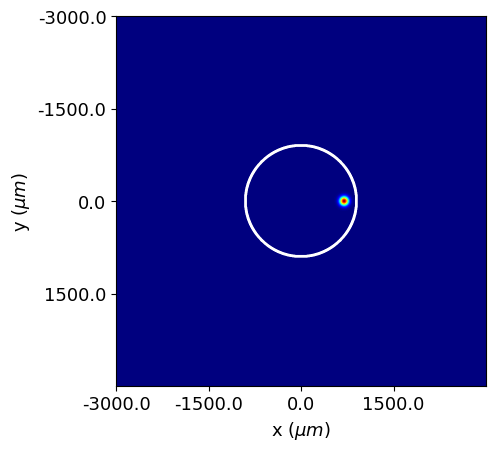

In [47]:
plot_beam_intensity(input_beam.field, indices=fiber.n)

In [17]:
output, fields, energies = run(domain, input_beam, fiber, wvl0, nonlinear=True, device=device)

Running simulation
Nonlinear: True


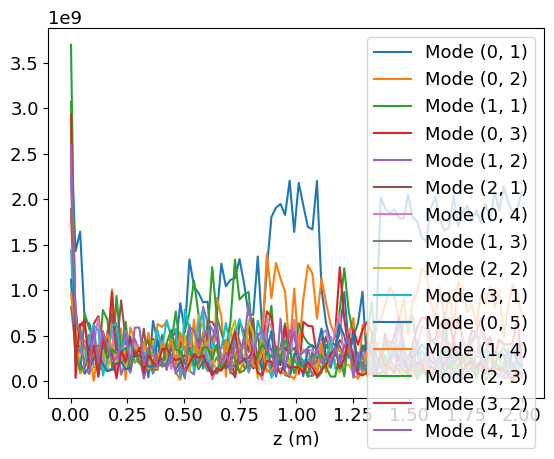

In [20]:
mode_arr = torch.zeros(num_mode, len(fields))
mode_indices = ((0, 1), (0, 2), (1, 1), (0, 3), (1, 2), (2, 1), (0, 4), (1, 3), (2, 2), (3, 1), (0, 5), (1, 4), (2, 3), (3, 2), (4, 1))
if type(fields) == torch.Tensor:
    fields = fields.to(device)
elif type(fields) == np.ndarray:
    fields = torch.tensor(fields).to(device)
for i in range(num_mode):
    mode = Input(domain, wvl0, n_core, n_clad, radius=radius, mode=mode_indices[i], coefficients2=coefficients2[i]).field
    # mode = mode.to(device)
    for j in range(len(fields)):
        overlap = torch.sum(mode * fields[j].conj())
        mode_arr[i, j] = torch.abs(overlap)
mode_arr = mode_arr.cpu().numpy()
z = np.linspace(0, total_z, len(fields))
for i in range(num_mode):
    plt.plot(z, mode_arr[i], label=f'Mode {mode_indices[i]}')
    plt.xlabel('z (m)')
    plt.legend()
    # plt.ylim(0, 1)

In [ ]:
plot_multiple_beams([input_beam.field.cpu().numpy(), output], indices=fiber.n)

In [21]:
output = output.cpu().numpy()
fields = fields.cpu().numpy()
energies = energies.cpu().numpy()

np.save('output_nonlinear.npy', output)
np.save('fields_nonlinear.npy', fields)
np.save('energies_nonlinear.npy', energies)

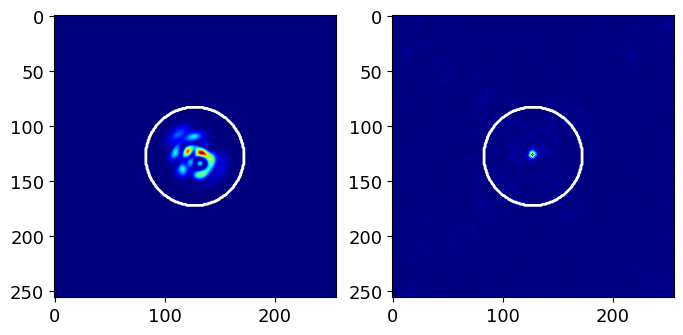

In [22]:
plot_multiple_beams([input_beam.field.cpu().numpy(), output], indices=fiber.n)

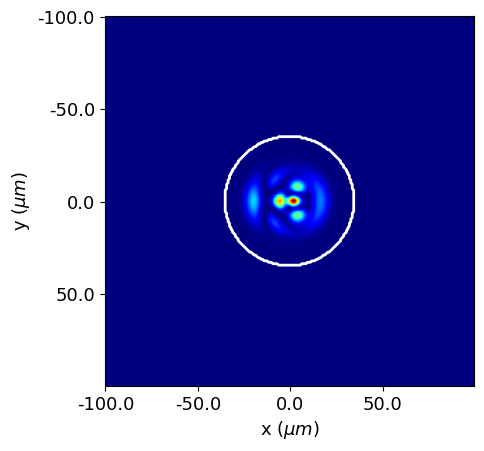

In [23]:
linear_field = np.load('output_linear.npy')
plot_beam_intensity(linear_field, indices=fiber.n)

## GRIN ROD

In [24]:
radius = 450e-6
Lx, Ly = 3000e-6, 3000e-6
Nx, Ny = 1024, 1024
total_z = 0.15
dz=1e-6


NA = 0.25
n_clad = 1.45
n_core = np.sqrt(NA**2 + n_clad**2)
n2 = 2.3e-20

wvl0 = 775e-9 # Wavelength (meter)

In [ ]:
np.random.seed(42)
# n2 = 3.2e-20
intensity = 5e18
amp = np.sqrt(intensity)

domain = Domain(Lx, Ly, Nx, Ny)
input_beam = Input(domain, wvl0, n_core, n_clad, radius=radius, gaussian=True, cx=0, cy=0, amp=amp)
fiber = Fiber(domain, n_core, n_clad, total_z, dz, radius=radius, n2=0)

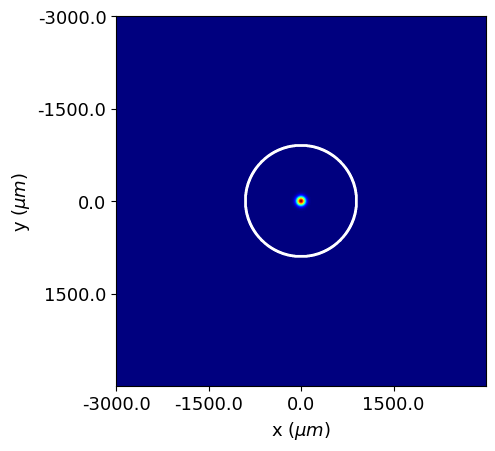

In [30]:
plot_beam_intensity(input_beam.field, indices=fiber.n)

In [31]:
output, fields, energies = run(domain, input_beam, fiber, wvl0, device=device)

Running simulation
Nonlinear: False


In [48]:
np.random.seed(42)
# n2 = 3.2e-20
intensity = 5e18
amp = np.sqrt(intensity)

domain = Domain(Lx, Ly, Nx, Ny)
input_beam = Input(domain, wvl0, n_core, n_clad, radius=radius, gaussian=True, cx=0e-6, cy=350e-6, amp=amp)
fiber = Fiber(domain, n_core, n_clad, total_z, dz, radius=radius, n2=0)

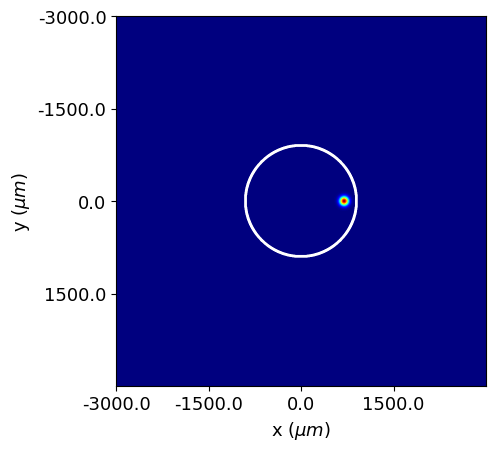

In [49]:
plot_beam_intensity(input_beam.field, indices=fiber.n)

In [50]:
output, fields, energies = run(domain, input_beam, fiber, wvl0, device=device)

Running simulation
Nonlinear: False


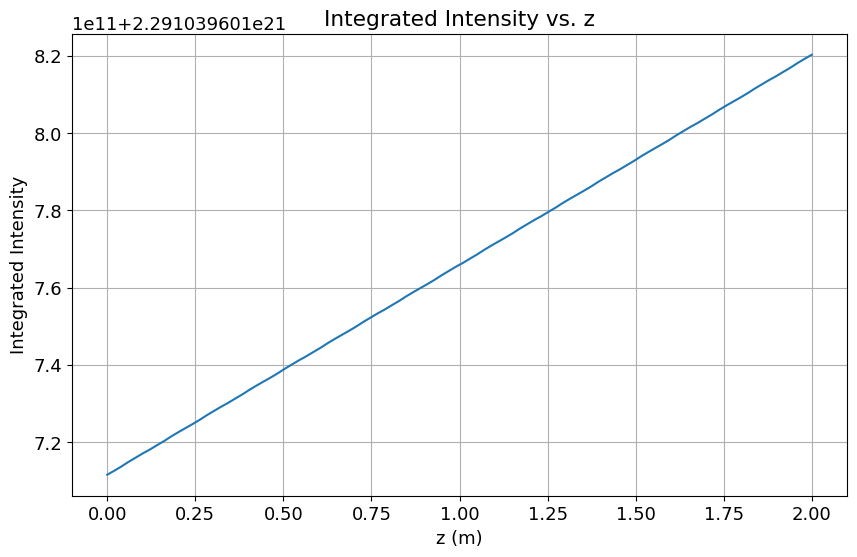

In [ ]:
# Integrate spatially in x, y coordinates
integrated_values = torch.sum(torch.abs(fields)**2, dim=(1, 2))

# Convert to numpy array for plotting
integrated_values = integrated_values.cpu().numpy()

# Plot the integrated values against z
plt.figure(figsize=(10, 6))
plt.plot(z, integrated_values)
plt.xlabel('z (m)')
plt.ylabel('Integrated Intensity')
plt.title('Integrated Intensity vs. z')
plt.grid(True)
plt.show()

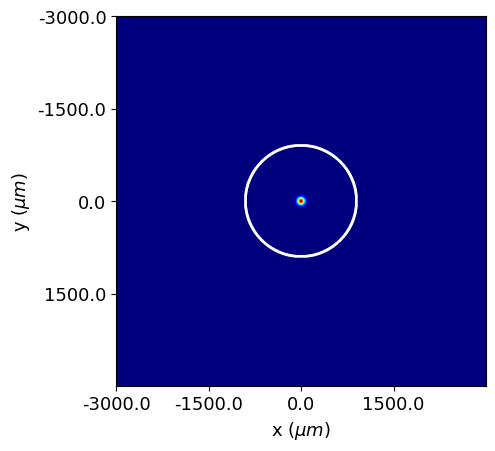

In [ ]:
output, fields, energies = run(domain, input_beam, fiber, wvl0, device=device)